In [5]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks

""" short time fourier transform of audio signal """
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))
    
    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    samples = np.append(np.zeros(np.floor(frameSize/2.0)), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))
    
    frames = stride_tricks.as_strided(samples, shape=(cols, frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win
    
    return np.fft.rfft(frames)    
    
""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))
    
    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,scale[i]:], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,scale[i]:scale[i+1]], axis=1)
    
    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[scale[i]:])]
        else:
            freqs += [np.mean(allfreqs[scale[i]:scale[i+1]])]
    
    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)
    s = stft(samples, binsize)
    
    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel
    
    timebins, freqbins = np.shape(ims)
    
    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()

    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])
    
    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()
        
    plt.clf()

In [6]:
plotstft("relief.wav")

/home/anton/.conda/envs/audio-ds/lib/python3.6/site-packages/scipy/io/wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [29]:
import wave
import sys

## This is how to extract the data from a stereo wave file

wr = wave.open("relief.wav", "rb")
sw = wr.getsampwidth()
f = wr.readframes(1)
# first channel
if1 = int.from_bytes(f[0:1], sys.byteorder, signed=True)
# second channel
if2 = int.from_bytes(f[2:3], sys.byteorder, signed=True)
print("sample width:", sw)
print("bytes per frame:", len(f))
print("channel values:")
print(if1, if2)

sample width: 2
bytes per frame: 4
channel values:
-12 8


rate: 44100


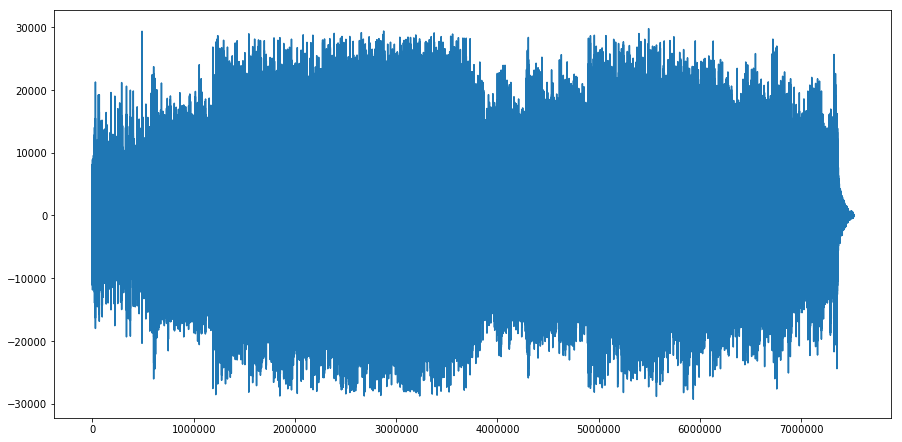

In [193]:
%matplotlib inline
import warnings
## scipy gives a waring when reading wav file
warnings.filterwarnings('ignore')

import scipy as sp
import numpy as np
from matplotlib import pyplot as plt

sample_rate, wav_data = sp.io.wavfile.read("relief.wav")
## taking the mean of the two channels
#mono_data = numpy.mean(wav_data, axis=1)
## taking just one channel
modo_data = wav_data[:, 0]
audio_data = mono_data

print("rate:", sample_rate)
plt.figure(figsize=(15, 7.5))
plt.plot(mono_data)
plt.show()

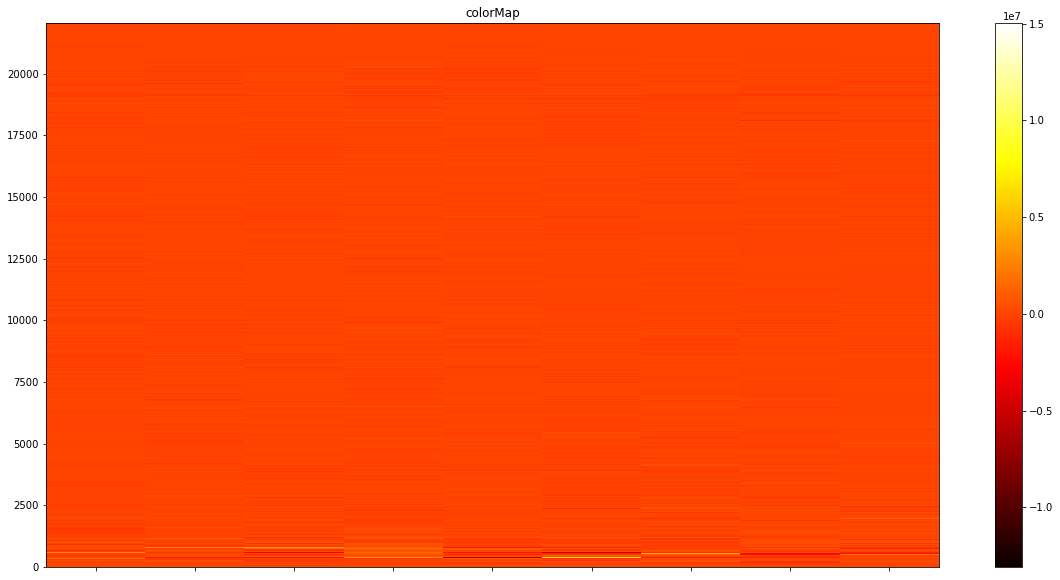

In [191]:
from numpy.lib.stride_tricks import as_strided

## moving onto creating a spectrogram
audio_data_ = audio_data[0:sample_rate*5]

def window(array, window_size):
    if (window_size % 2 != 0):
        raise Exception("window size must be divisible even")
    step_size = int(window_size / 2)
    chunks_num = int((len(array)-window_size)/step_size)+1
    res = [array[i:i+window_size] for i in range(0, chunks_num*step_size, step_size)]
    return np.array(res, array.dtype)
          
windowed_data = window(audio_data_, sample_rate)

fft = [np.fft.rfft(frame) for frame in windowed_data]
fft = np.transpose(np.real(np.array(fft)))
# fft = np.absolute(np.transpose(np.real(np.array(fft))))
# fft = np.log10(fft) * 20

xlabels = range(0, )
# fft = np.real(np.array(fft))

# print(windowed_data)
# print(fft)
# print(fft.shape)


fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(fft, cmap='hot')
ax.set_aspect('auto')
ax.set_ylim([0,fft.shape[0]])
ax.set_xticklabels(xlabels)
plt.colorbar(orientation='vertical')
plt.show()

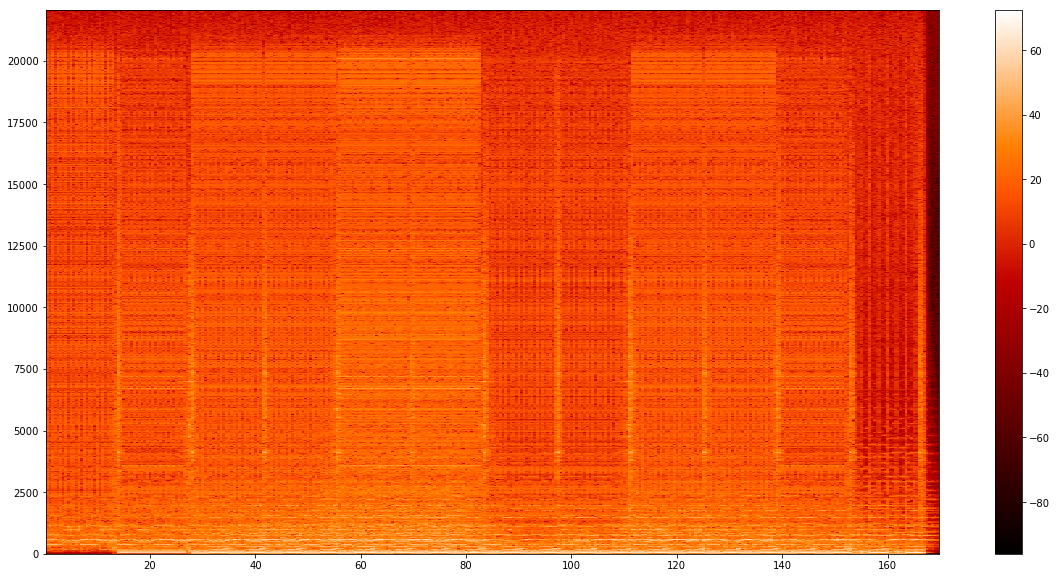

[  0.00000000e+00   1.00000000e+00   2.00000000e+00 ...,   2.20480000e+04
   2.20490000e+04   2.20500000e+04]


In [206]:

time_limit = 10 * sample_rate
# audio_data_ = audio_data[0:time_limit]
audio_data_ = audio_data
NFFT = sample_rate     # the length of the windowing segments
Fs = sample_rate  # the sampling rate

# plot signal and spectrogram
fig = plt.figure(figsize=(20, 10))
pxx, freqs, bins, im = plt.specgram(audio_data_, NFFT=NFFT,   Fs=Fs,noverlap=int(sample_rate/2), 
                                    cmap=plt.cm.gist_heat, scale='dB', scale_by_freq=True)

plt.colorbar(orientation='vertical')
plt.show()

print(freqs)